In [1]:
import os
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
from hapi import *
from spectral import *
import os
import spectral.io.envi as envi
from astropy.nddata import block_reduce
from scipy.interpolate import interp1d
import numba as nb
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
import pandas as pd


HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

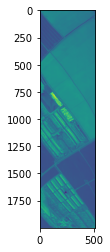

In [101]:
direct = os.getcwd()

"""
Downlaoad HyTES data from JPL
The files below correspond to the plume emitted from the dairy farm in this article (Fig.9)
doi:10.5194/amt-9-2393-2016
"""

hdrfile = os.path.join(direct,'2015-02-08.190936.FeedlotsSouth.Line4-Run1-Segment01-110000-level_1a.hdr')
imgfile = os.path.join(direct,'2015-02-08.190936.FeedlotsSouth.Line4-Run1-Segment01-110000-level_1a.dat')

lib = envi.open(hdrfile)
img = envi.open(hdrfile,imgfile)

# Take slice of array if too large
#p1=1810 ; p2 =2020 
#q1=380  ; q2 =500
p1=0 ; p2 =2000 
q1=0  ; q2 = img.shape[1]

data_array = img[p1:p2,q1:q2,:]

plt.imshow(data_array[:,:,100])
plt.show()

In [49]:
# HyTES wavelength per channel
wvl = np.genfromtxt('HyTES_Wvl_Micron.txt',delimiter=' ')
wvl = wvl * 1000

In [102]:
# only want methane bands, exclude the rest: i.e only want 7500nm<lambda<8000nm
idx = np.where(wvl>7500)[0]
wvl=wvl[idx]
data_array = data_array[:,:,idx]

idx = np.where(wvl<8000)[0]
wvl=wvl[idx]
data_array = data_array[:,:,idx]

print(wvl.shape,data_array.shape)

(27,) (2000, 512, 27)


In [5]:
# get min/max range in wavenumber.
cm_min =1e7/np.nanmax(wvl)
cm_max =1e7/np.nanmin(wvl)

#potentially fetch x-sections from HITRAN database, then put them into folder 'CH4_HyTES'
if(os.path.exists(os.path.join(direct,'CH4_HyTES')) == False):
    fetch('CH4',6,1,cm_min-100,cm_max+100)
    os.system("mkdir CH4_HyTES | cp CH4.data CH4.header CH4_HyTES")

Using CH4_HyTES

CH4
                     Lines parsed: 22977
{'air': 1.0}
5.876931 seconds elapsed for abscoef; nlines = 22977


In [ ]:
# calculate absorption coefficients
data = db_begin('CH4_HyTES')
nu,coef = absorptionCoefficient_Voigt(data,SourceTables='CH4', Diluent={'air':1.0},HITRAN_units=False)
nu,absorp = absorptionSpectrum(nu,coef,Environment={'T': 296.0, 'l': 1.0})


In [12]:
#Here we need to load the LUT SRF measurements and convolve our high res spectra with the LUT
def F_isrf_convolve_fft(w1, s1, w2, isrf_dw0, isrf_lut0):
    """
    astropy.covolute.convolve_fft-based convolution using wavelength-dependent isrf
    w1:
        high-resolution wavelength
    s1:
        high-resolution spectrum
    w2:
        low-resolution wavelength
    isrf_dw0:
        wavelength grid on which isrfs are defined
    isrf_lut0:
        instrument spectral response function look up table
    """
    from astropy.convolution import convolve_fft
    from scipy.interpolate import RegularGridInterpolator, interp1d
    from math import isclose
    from scipy import interpolate, optimize

    # make sure w1 and isrf_dw have the same resolution
    w1_step = np.median(np.diff(w1))

    #isrf_dw_min = np.min(isrf_dw0)
    #isrf_dw_max = -isrf_dw_min
    #isrf_dw = np.linspace(isrf_dw_min, isrf_dw_max, int((isrf_dw_max - isrf_dw_min) / w1_step) + 1)
    isrf_lut = np.zeros((isrf_lut0.shape))

    for i in range(isrf_dw0.shape[0]):
        interp_func = interpolate.interp1d(isrf_dw0[i,:], isrf_lut0[i, :])
        isrf_lut[i, :] = interp_func(isrf_dw0[i,:])


    # note that the isrf is flipped: convolution is the mirror-image of kernel averaging
    s2_fft_lut = np.array([convolve_fft(s1, isrf_lut[iw, ::-1]) for iw in range(isrf_dw0.shape[0])])

    inter_func = RegularGridInterpolator((isrf_dw0[:,0], w1), s2_fft_lut, bounds_error=False)
    

    return inter_func((w2, w2))

In [39]:
# Instrument ISRF parameters
srf_data = np.genfromtxt('HyTES_SRF_v6.csv',delimiter=',',skip_header=2)[:,1:]
wmx_data = np.genfromtxt('HyTES_WMX_v6.csv',delimiter=',',skip_header=2)[:,1:]*1000

In [40]:
# convolve high resolution spectra (x-sections) to ISRF of the instrument
s2 = F_isrf_convolve_fft(1e7/nu[::-1],absorp[::-1],wvl,wmx_data,srf_data)

(256, 27715)
(256, 7) (27715,)
[ 7439.3  7456.9  7474.5  7492.2  7509.8  7527.4  7545.   7562.6  7580.3
  7597.9  7615.5  7633.1  7650.7  7668.4  7686.   7703.6  7721.2  7738.8
  7756.5  7774.1  7791.7  7809.3  7826.9  7844.6  7862.2  7879.8  7897.4
  7915.   7932.7  7950.3  7967.9  7985.5  8003.1  8020.8  8038.4  8056.
  8073.6  8091.2  8108.9  8126.5  8144.1  8161.7  8179.3  8197.   8214.6
  8232.2  8249.8  8267.5  8285.1  8302.7  8320.3  8337.9  8355.6  8373.2
  8390.8  8408.4  8426.   8443.7  8461.3  8478.9  8496.5  8514.1  8531.8
  8549.4  8567.   8584.6  8601.9  8619.6  8638.2  8654.8  8672.4  8690.
  8707.7  8726.3  8742.9  8760.5  8779.1  8795.8  8813.4  8831.   8848.6
  8867.2  8883.9  8901.5  8920.1  8936.7  8954.3  8973.   8989.6  9007.2
  9025.8  9042.4  9060.1  9078.7  9095.3  9112.9  9130.5  9148.2  9166.8
  9183.4  9201.   9219.6  9236.3  9253.9  9272.5  9289.1  9306.7  9325.4
  9342.   9359.6  9378.2  9394.8  9412.5  9430.1  9447.7  9466.3  9482.9
  9500.6  9519.2  9535

In [104]:
# define knn clusters
knn=30
model = KMeans(knn)
model.fit(np.nanmean(data_array,axis=2).flatten().reshape(-1,1))
pred = model.fit_predict(np.nanmean(data_array,axis=2).flatten().reshape(-1,1))

(2000, 512) (2000, 512, 27)


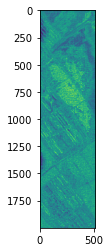

(2000, 512)


In [105]:
# reshape cluster prediction vector to image array shape 
pred=np.reshape(pred,(data_array.shape[0],data_array.shape[1]))
print(pred.shape,data_array.shape)
plt.imshow(pred)
plt.show()
plt.close()
print(pred.shape)

In [106]:
#create knn cluster means
mu = np.zeros((knn,data_array.shape[2]))
for i in range(knn):
    mn = np.nanmean(data_array,axis=2).flatten()
    idx = np.logical_and(pred.flatten()==i,pred.flatten()==i)#[0]
    mu[i,:] = np.nanmean(mn[idx]) 


In [118]:
# calculate matched filter, alpha_x
data=data_array
alpha_x = np.zeros((data.shape[0],data.shape[1]))
for i in tqdm(range(data.shape[0])):
    r = data[i,:,:]

    # calculate covariance matrices
    K = np.zeros((mu.shape[1],mu.shape[1]))
    # loop over xtrack positions
    for j in range(data.shape[1]):
        pred_now = pred[i,j]
        p1 = r[j,:] - mu[pred_now,:]
        K[:,:] = K[:,:] + p1[...,np.newaxis] @ p1[...,np.newaxis].T

    K[:,:] = K[:,:] / r.shape[0]
    
    Kinv = np.linalg.inv(K) 

    for j in range(data.shape[1]):
        pred_now = pred[i,j]
        bnew = b * mu[pred_now,:]
        bnew = s2 * mu[pred_now,:]
        p1 = (r[j,:] - mu[pred_now,:])
        p1 = p1[...,np.newaxis].T
        x=p1 @ Kinv @ bnew[...,np.newaxis]
        alpha_x[i,j] = p1 @ Kinv @ bnew[...,np.newaxis]
        denom = bnew[...,np.newaxis].T @ Kinv @ bnew[...,np.newaxis]
        alpha_x[i,j] = alpha_x[i,j] / denom

(2000, 512, 27)
(2000, 512)


100%|██████████| 2000/2000 [00:18<00:00, 106.57it/s]


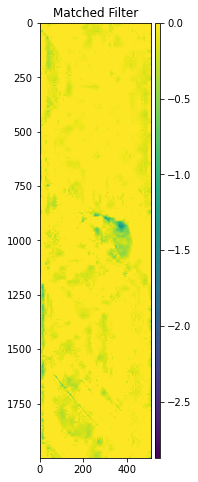

In [122]:
from MSATwtdenoiser import MSATdenoise
# maybe de-noise if necessary
denoiser = MSATdenoise(alpha_x_sc,'db3',5)
denoised_img = denoiser.denoised

std = np.nanstd(denoised_img)
mn = np.nanmean(denoised_img)

idx=np.logical_and(abs(denoised_img)<(2*std+mn),abs(denoised_img)>(mn-2*std))

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
im1 = ax1.imshow(denoised_img,vmax=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax1.set_title('Matched Filter')
fig.colorbar(im1, cax=cax, orientation='vertical')



plt.show()
plt.close()

In [87]:
# Let us plot it on GEE.
import make_kmz_v2
from palettable import colorbrewer

ModuleNotFoundError: No module named 'make_kmz_v2'

In [ ]:
filter1d = alpha_x

idx=np.isfinite(lon)
print(idx.shape)


pixels = 1024 #* 10
cmap = colorbrewer.get_map('RdYlGn', 'diverging', 11, reverse=True).mpl_colormap

fig, ax = make_kmz_v2.gearth_fig(llcrnrlon=np.nanmin(lon),
                     llcrnrlat=np.nanmin(lat),
                     urcrnrlon=np.nanmax(lon),
                     urcrnrlat=np.nanmax(lat),
                     pixels=pixels)
cs = ax.imshow(alpha_x[:,:],vmax=0,vmin=-20, cmap=cmap,extent=[np.nanmin(lon), np.nanmax(lon),\
                                             np.nanmin(lat), np.nanmax(lat)])
plt.savefig('overlay1.png', transparent=False, format='png')


#name='avris_aliso_canyon_2016.kml'


In [ ]:
fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('Emission', rotation=-90, color='k', labelpad=20)
fig.savefig('legend.png', transparent=False, format='png')  # Change transparent to True if your colorbar is not on space :)

In [ ]:
make_kmz_v2.make_kml(llcrnrlon=np.nanmin(lon),
                     llcrnrlat=np.nanmin(lat),
                     urcrnrlon=np.nanmax(lon),
                     urcrnrlat=np.nanmax(lat),
         figs=['overlay1.png'], colorbar='legend.png',
         kmzfile='aviris_aliso_canyon_2016.kmz', name='CH4 Emission')